<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/fourier_slice_2D_3D_with_trilinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* implement Fourier slice theorem in 3D to 2D case


# Setup

In [38]:
!pip install mrcfile
import mrcfile

     |████████████████████████████████| 51kB 5.7MB/s 


In [67]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/fourier.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/interp.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/twod.py
!wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py # needed for twod import
!pip install pyfftw
import coords, interp, fourier, twod

--2021-04-01 12:54:20--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/coords.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1681 (1.6K) [text/plain]
Saving to: ‘coords.py.1’

coords.py.1         100%[===================>]   1.64K  --.-KB/s    in 0s      

2021-04-01 12:54:20 (27.2 MB/s) - ‘coords.py.1’ saved [1681/1681]

--2021-04-01 12:54:20--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/master/src/fourier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1083 (1.1K) [tex

In [14]:
import numpy as np
import matplotlib.pyplot as plt
def doplt(arr2d,cmap='gray',**kwargs):
  plt.imshow(arr2d,cmap=cmap,**kwargs)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 2D $\rightarrow$ 3D  reconstruction in Fourier space

Fourier slice theorem with trilinear interpolation.

We can interpolate one 2D slice at a time into the 3D Fourier volume using trilnear interpolation.

Pseudo code
```
# for random angels (uniform on sphere)
  # rotate real spaced 3D map
  # make 3D -> 2D real space projection of the rotated map
  # make 2D FFT of 2D real space projection
  # get original coords of 2D slice 
  # rotate (x,y,z=0) plane coords (z values varry after rotation)
  # interpolate (trilinear) rotated slice and insert to 3D Fourier volume (keep track of interpolation counts)
# inverse FFT (wiener filter by interpolation counts)
```

## Simulate data


Let's try a simple example of some gaussian blobs

Ensure enough zero-padding that there are no artefacts from aliasing

In [78]:
def gauss(x,y,z,std,cx,cy,cz):
    return np.exp(-(cx*x*x+cy*y*y+cz*z*z)/(2*std**2))

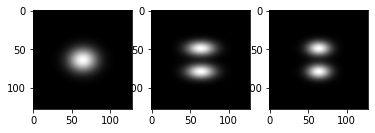

In [79]:
N=128
coords_1d = np.arange(-N//2,N//2)
y,x,z = np.meshgrid(coords_1d,coords_1d,coords_1d) # note order of output! comes from meshgrid
cx,cy,cz = np.array([2,.75,.5])*2
mux = 15
muy = 0
muz= 0
std = N/10
map_original = gauss(x-mux,y-muy,z-muz,std=std,cx=cx,cy=cy,cz=cz)
map_original += gauss(x+mux,y+muy,z+muz,std=std,cx=cx,cy=cy,cz=cz)

fig,ax = plt.subplots(nrows=1,ncols=3)
for idx in range(3):
  ax[idx].imshow(np.nansum(map_original, axis=idx),cmap='gray')

Now we can generate 2D slices. There are a few ways to do this
  * in Fourier space
    * take 3D FFT of the map
    * rotate the xy plane
    * interpolate the values of the Fourier volume onto these points
  * in real space
    * rotate the $N^3$ grid xyz grid points
    * interpolate on the the unrotated xyz grid, using the new rotated points with the original function values at the unrotated points.

Both methods above will work for any arbitrary map. Doing things in real space avoids Fourier artefacts, but can take longer. However, since we have the analytical form of the map (it's a toy example with a simple shape), we can just rotate the coordinates and compute it on the same 3D grid.

Ensure rotations uniform over the sphere. With experimental data, the rotations would have to be estimated.

In [192]:
def get_random_quat(num_pts):
    """
    Get num_pts of unit quaternions on the 4 hemisphere with a uniform random distribution.
    :param num_pts: The number of quaternions to return
    :return: Quaternion list of shape [number of quaternion, 4]
    """
    u = np.random.rand(3, num_pts)
    u1, u2, u3 = [u[x] for x in range(3)]

    quat = np.zeros((4, num_pts))
    quat[0] = np.sqrt(1 - u1) * np.sin(np.pi * u2 / 2)
    quat[1] = np.sqrt(1 - u1) * np.cos(np.pi * u2 / 2)
    quat[2] = np.sqrt(u1) * np.sin(np.pi * u3 / 2)
    quat[3] = np.sqrt(u1) * np.cos(np.pi * u3 / 2)

    return np.transpose(quat)

def quaternion_to_R(q):
  a,b,c,d = q[0], q[1], q[2], q[3]
  R = np.array([
                [a**2+b**2-c**2-d**2 , 2*b*c-2*a*d , 2*b*d+2*a*c],
                [2*b*c+2*a*d , a**2-b**2+c**2-d**2 , 2*c*d-2*a*b],
                [2*b*d-2*a*c , 2*c*d+2*a*b , a**2-b**2-c**2+d**2]
                ])
  return(R)

def logmap(R):
    if R.shape == (3,2):
        R_ = np.empty((3,3))
        R_[:,:2] = R
        R_[:,2] = np.cross(R[:,0], R[:,1])
        R = R_
    arg = np.clip(0.5 * (np.trace(R) - 1), -1.0, 1.0)
    angle = np.arccos(arg)
    eps = 1e-6
    if angle < eps:
        a = np.zeros(3)
    elif angle > np.pi - eps:
        # from https://math.stackexchange.com/questions/83874/efficient-and-accurate-numerical-implementation-of-the-inverse-rodrigues-rotatio/110059
        B = (0.5* (R + np.eye(3))) 
        i = np.unravel_index(B.ravel().argmax(), B.shape)[0]
        a = B[i] 
        a = a / np.linalg.norm(a)
    else:
        a = 1.0/2.0/np.sin(angle) * \
            np.array([R[2,1] - R[1,2],
                     R[0,2] - R[2,0],
                     R[1,0] - R[0,1]])
    return angle*a

def expmap(e):
    angle = np.linalg.norm(e)
    if angle < 1e-16:
        return np.identity(3, dtype=e.dtype)
    k = e/angle
    K = np.array([[    0,-k[2], k[1]],\
                 [ k[2],    0,-k[0]],\
                 [-k[1], k[0],   0]],dtype=e.dtype)
    return np.identity(3, dtype=e.dtype) + np.sin(angle)*K + (1-np.cos(angle))*np.dot(K,K)

In [81]:
n_particles=100
np.random.seed(0)
qs = get_random_quat(n_particles)
Rs = quaternion_to_R(qs.T)
Rs = np.swapaxes(Rs,0,-1)
Rs = np.swapaxes(Rs,1,-1)
Rs.shape

(100, 3, 3)

In [82]:
xyz = coords.coords_n_by_d(coords_1d,d=3)
xyz.shape

(2097152, 3)

`xyz` is the coordinate of every voxel in a 3D grid of box length `N`

In [83]:
%%time
projs = np.zeros((n_particles,N,N))
for idx in range(n_particles):
  xyz_rot = Rs[idx].dot(xyz.T).T
  # match original want to recover
  map_rot = gauss(x=xyz_rot[:,0]-mux,y=xyz_rot[:,1]-muy,z=xyz_rot[:,-1]-muz,std=std,cx=cx,cy=cy,cz=cz).reshape(N,N,N)
  map_rot += gauss(x=xyz_rot[:,0]+mux,y=xyz_rot[:,1]+muy,z=xyz_rot[:,-1]+muz,std=std,cx=cx,cy=cy,cz=cz).reshape(N,N,N)
  projs[idx] = map_rot.sum(-1) # z axis

CPU times: user 22.5 s, sys: 33.7 s, total: 56.3 s
Wall time: 17.6 s


Let's look at the projection (each of the x,y,z axes) of one rotated map. Note that we only save the projection corresponding to the z axis.

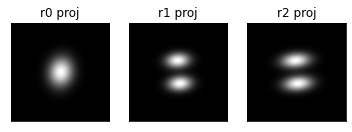

In [84]:
fig,ax = plt.subplots(nrows=1,ncols=3)
for idx in range(3):
  ax[idx].imshow(np.nansum(map_rot, axis=idx),cmap='gray') ; ax[idx].set_xticks([]) ; ax[idx].set_yticks([])
  ax[idx].set_title('r%i proj'%idx)

## Insert Fourier slices



2D Fourier transform of slices is very fast compared to simulating the data (or inserting the slices)

In [85]:
%%time
proj_2d_fs = np.zeros((n_particles,N,N),dtype=np.complex64)
for idx in range(n_particles):
  proj_2d_fs[idx] = twod.do_fft(projs[idx])

CPU times: user 62.1 ms, sys: 2.87 ms, total: 65 ms
Wall time: 64 ms


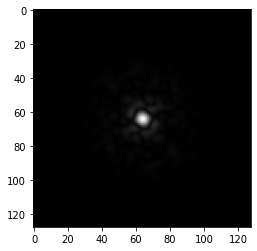

In [306]:
doplt(np.abs(proj_2d_fs[2]))

Now we can place the slices in Fourier volume, with the correct rotation.

`xy0_rot` is the kx,ky,kz Fourier coordiantes of the rotated slice (xy0). We know the value of the 3D Fourier volume at these locations - they are the projections.

However, the coordinate values are not on the cartesian grid. We can use trilinear interpolation to get them on the grid, doing one slice at a time.

In [86]:
%%time
F_3d_interp = np.zeros((N,N,N)).astype(np.complex64)
count_3d_interp = np.zeros((N,N,N))
idx_z0 = xyz[:,-1] == 0 
xy0 = xyz[idx_z0]
for idx in range(n_particles): 
  xy0_rot = Rs[idx].dot(xy0.T).T # rotation (not inverse) because matches corresponding rotation of slice (not matching against library of unrotated references, because not searching for best alignment)
  r0,r1,dd = interp.diff(xy0_rot[:,:])
  F_3d_interp_slice,count_3d_interp_slice = interp.interp_vec(proj_2d_fs[idx],r0,r1,dd,N)
  F_3d_interp += F_3d_interp_slice
  count_3d_interp += count_3d_interp_slice

CPU times: user 2.96 s, sys: 121 ms, total: 3.09 s
Wall time: 3.08 s


In [304]:
Rs[1]

array([[-0.43037873,  0.56031001,  0.7076912 ],
       [ 0.90138786,  0.22536033,  0.36974674],
       [ 0.04768727,  0.79703539, -0.60204693]])

In [307]:
xy0_rot

array([[-70.37540489,   4.67844095,  56.72225821],
       [-70.26661546,   4.50721341,  55.74305139],
       [-70.15782603,   4.33598588,  54.76384457],
       ...,
       [ 69.05821033,  -4.26288524, -53.87755929],
       [ 69.16699976,  -4.43411277, -54.85676611],
       [ 69.27578919,  -4.60534031, -55.83597293]])

We can see a single planes by summing across an axis of a `count_3d_interp_slice`. Note the holes in it - artefacts from the interpolation

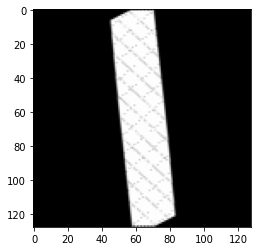

In [ ]:
doplt(count_3d_interp_slice.sum(2))

We can see how much the Fourier volume has been filled out by looking at `count_3d_interp`, which is of all the particles

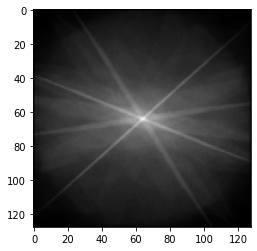

In [ ]:
doplt(count_3d_interp.sum(2))

Normally we would also have a CTF for each particle, and we could deconvolute it when we divide by the counts. Here we had no CTF (they are all taken as 1 and have no effect - no frequency dependence).

## Take the iFFT to get the real spaced map

To get the final real space volume we take the 3D iFFT of the Wiener filtered volume.

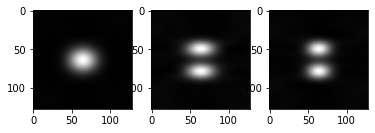

In [87]:
wf_const = 1
F_3d_wf = F_3d_interp*count_3d_interp / (wf_const + count_3d_interp**2)
map_recon_3d = fourier.do_ifft(F_3d_wf)

fig,ax = plt.subplots(nrows=1,ncols=3)
for idx in range(3):
  ax[idx].imshow(np.nansum(map_recon_3d.real, axis=idx),cmap='gray')

The imaginary part should be small and comes from some sort of numerical issue or finite number of particles.

In [ ]:
np.linalg.norm(map_recon_3d.real)/np.linalg.norm(map_recon_3d.imag)

76.02990514134503

## Conclusions

Play around with things to build your intuition.

Are there any artefacts?

What happens where there are 
  * less particles?
  * errors in the alignments?



# Calmodulin

In [19]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/fa1bc0c01cafa40a1e9bba7dbbcd83912ddd6ba6/src/gauss_forward_model.py
import gauss_forward_model

--2021-04-01 12:30:29--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/fa1bc0c01cafa40a1e9bba7dbbcd83912ddd6ba6/src/gauss_forward_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1911 (1.9K) [text/plain]
Saving to: ‘gauss_forward_model.py’

gauss_forward_model 100%[===================>]   1.87K  --.-KB/s    in 0s      

2021-04-01 12:30:29 (43.8 MB/s) - ‘gauss_forward_model.py’ saved [1911/1911]



In [5]:
!pip install gemmi

     |████████████████████████████████| 2.3MB 12.1MB/s 


In [4]:
!wget https://files.rcsb.org/view/6OS4.cif 

--2021-04-01 12:15:45--  https://files.rcsb.org/view/6OS4.cif
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.66
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘6OS4.cif’

6OS4.cif                [  <=>               ] 269.93K   860KB/s    in 0.3s    

2021-04-01 12:15:45 (860 KB/s) - ‘6OS4.cif’ saved [276404]



In [6]:
import gemmi

In [11]:
def cif2model(filename):
    cif_block = gemmi.cif.read(filename)[0]
    st = gemmi.make_structure_from_block(cif_block)
    st.remove_alternative_conformations()
    st.remove_hydrogens()
    st.remove_waters()
    st.remove_ligands_and_waters()
    st.remove_empty_chains()
    model = gemmi.make_assembly(st.assemblies[0], st[0], gemmi.HowToNameCopiedChain.AddNumber)
    return model

def pos_as_array(model):
    """returns a numpy array of atomic positions from gemmi model """
    pos = []
    for ch in model:
        for res in ch:
            for at in res:
                pos.append([at.pos.x,at.pos.y,at.pos.z])
    return np.array(pos)
    
def com_as_array(model):
    """returns a numpy array of center of mass from gemmi model """
    com = model.calculate_center_of_mass()
    array = np.zeros(3)
    array[0] = com.x
    array[1] = com.y
    array[2] = com.z
    return array

In [294]:
filename = '6OS4.cif'
model = cif2model(filename)
pos = pos_as_array(model)
com = com_as_array(model)
pos -= com
atoms = pos.T

atoms.shape


(3, 1093)

In [103]:
# atoms = np.array([[-10,-10,-10],
#                  [10,10,10]]).T

In [21]:
import coords

In [310]:
N=128
xy = coords.coords_n_by_d(np.arange(-N//2,N//2),d=2)
# xy[:,[0,1]] = xy[:,[1,0]]


In [312]:
sigma=1
offset=N/4
atoms += offset
proj_2d = gauss_forward_model.make_proj_mask(atoms, xy, sigma=sigma, n_trunc=2*3*sigma,parallel_diff=True)

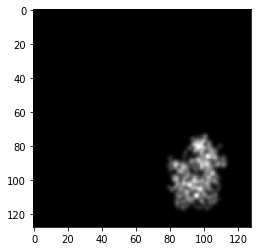

In [313]:
doplt(proj_2d)

Let's see what this looks like in 3D (export to mrc and look at in Chimera)

## export: atoms $\rightarrow$ 3D map

In [289]:
xyz = coords.coords_n_by_d(np.arange(-N//2,N//2),d=3)


In [263]:
map_3d = gauss_forward_model.make_map_3d(atoms,xyz,sigma=1)

In [50]:
wdir = '/content/drive/My Drive/repos/learn_cryoem_math/data/fourier_slice_2D_3D_with_trilinear/'

In [245]:
with mrcfile.new(wdir+'6OS4_sigma1_N%i.mrc'%N, overwrite=True) as mrc:
  mrc.set_data(map_3d.astype(np.float32))

# Simulate projections

In [246]:
n_particles=100
np.random.seed(0)
qs = get_random_quat(n_particles)
Rs = quaternion_to_R(qs.T)
Rs = np.swapaxes(Rs,0,-1)
Rs = np.swapaxes(Rs,1,-1)
Rs.shape

(100, 3, 3)

In [256]:
n_particles=100
np.random.seed(1)
qs = get_random_quat(n_particles)
Rs_rand = quaternion_to_R(qs.T)
Rs_rand = np.swapaxes(Rs_rand,0,-1)
Rs_rand = np.swapaxes(Rs_rand,1,-1)
Rs_rand.shape

(100, 3, 3)

Error in alignments

In [308]:
deg_err = 3
alignment_error = np.deg2rad(deg_err)
Rs_error = np.zeros_like(Rs)
for idx in range(n_particles):

  e = logmap(Rs[idx])
  theta = np.linalg.norm(e)
  k = e/theta
  
  e_ = (theta + np.random.uniform(low=-alignment_error,high=alignment_error))*k
  Rs_error[idx] = expmap(e_)
e_, e

(array([1.73313095, 0.15309737, 0.00943057]),
 array([1.77371663, 0.15668253, 0.00965141]))

In [309]:
Rs[0], Rs_error[0]

(array([[-0.09762701, -0.54119008,  0.83521391],
        [ 0.99509059, -0.0667741 ,  0.07304744],
        [ 0.01623811,  0.8382449 ,  0.54505211]]),
 array([[-0.06297079, -0.55844286,  0.82714947],
        [ 0.99801203, -0.03309203,  0.05363674],
        [-0.002581  ,  0.82888267,  0.55941653]]))

In [297]:
projs = np.zeros((n_particles,N,N))
for idx in range(n_particles):
  atoms_rot = Rs[idx].dot(atoms)
  projs[idx] = gauss_forward_model.make_proj_mask(atoms_rot, xy, sigma=sigma, n_trunc=2*3*sigma,parallel_diff=True).T # xy vs yx to need to transpose

Text(0.5, 1.0, 'proj 100')

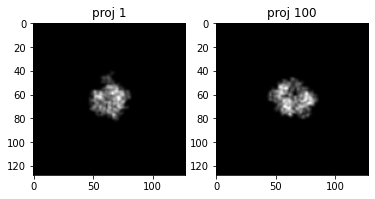

In [298]:
fig,axes = plt.subplots(ncols=2)
axes[0].imshow(projs[0],cmap='gray') ; axes[0].set_title('proj 1')
axes[1].imshow(projs[-1],cmap='gray')  ; axes[1].set_title('proj %i'%n_particles)

# Reconstruct

## Insert Fourier slices

In [299]:
proj_2d_fs = np.zeros((n_particles,N,N),dtype=np.complex64)
for idx in range(n_particles):
  proj_2d_fs[idx] = twod.do_fft(projs[idx])

In [300]:
F_3d_interp = np.zeros((N,N,N)).astype(np.complex64)
count_3d_interp = np.zeros((N,N,N))
idx_z0 = xyz[:,-1] == 0 
xy0 = xyz[idx_z0]
rand_frac = 0
for idx in range(n_particles): 
  if idx/n_particles < rand_frac:
    xy0_rot = Rs_rand[idx].T.dot(xy0.T).T # completely random
  else:
    xy0_rot = Rs_error[idx].T.dot(xy0.T).T # inverse rotation
  r0,r1,dd = interp.diff(xy0_rot[:,:])
  F_3d_interp_slice,count_3d_interp_slice = interp.interp_vec(proj_2d_fs[idx],r0,r1,dd,N)
  F_3d_interp += F_3d_interp_slice
  count_3d_interp += count_3d_interp_slice

## iFFT

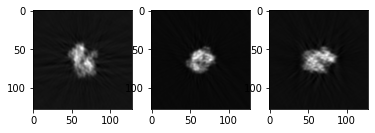

In [301]:
wf_const = 1
F_3d_wf = F_3d_interp*count_3d_interp / (wf_const + count_3d_interp**2)
map_recon_3d = fourier.do_ifft(F_3d_wf)

fig,ax = plt.subplots(nrows=1,ncols=3)
for idx in range(3):
  ax[idx].imshow(np.nansum(map_recon_3d.real, axis=idx),cmap='gray')

Export

In [302]:
map_3d = map_recon_3d.real
with mrcfile.new(wdir+'6OS4_reconst_err_aa%.1fdeg_rf%.2f_sigma%.2f_N%i_offset%i_np%i.mrc'%(deg_err,rand_frac,sigma,N,offset,n_particles), overwrite=True) as mrc:
  mrc.set_data(map_3d.astype(np.float32))